## 7: Classification - Part 2

Eva Dyer, BMED 6517

___

### 1. Support Vector Machines (SVMs)

There are infinitely many lines that have equal cost for a linearly-separable dataset. The line that you find will depend on the approximation used, and can also depend on the initial guesses for the parameter $\beta$, i.e. the coefficients of your model.

The idea of a **support vector machine** is to regularize the cost function so that the "margins" that define the buffer zone between two classes are maximized. This is intuitive since it allows the classifier to remain accurate even as data falls outside the original bounds.

**Note:** In the figure below, w = $\beta$ and b = $\beta_0$.<br>Also, We will be working with $X \in R^{Nxd}$ as per our usual convention, and therefore use $\textbf{x}$ and not $\textbf{x}^T$  


margin_size.png

We can classify points based on where they lie in relation to these margins. The inequality $\beta_0 + \vec{x} \vec{\beta} \geq 1$ describes all of the points above the upper margin, so we'll consider points for which it is true to belong to the red class, and all points $x_i$ for which $\beta_0 + \vec{x_i} \vec{\beta} \leq -1$ is true will be classified as blue. If we label these classes such that $y_i = 1$ for all red points and $y_i = -1$ for all blue points, then we can summarize both of these inequalities in one, such that $$y_i(\beta_0 + \vec{x_i} \vec{\beta}) > 1.$$

To make this classifier as robust as possible, we want to maximize the distance between the margins. Geometrically the distance between these planes is $2 / \|\vec{\beta}\|_2$, which means the margin is maximized when $||\vec{\beta}||_2$ is minimized. But this is nothing but an $L_2$ penalty on the weights!

However, there's a problem here: What happens when the classes are <i>not</i> linearly separable, and there's no such margin to maximize? The solution to this problem is called the <i>hinge loss function</i>:

$$\max (0, 1 - y_i(\beta_0 + \vec{x_i} \vec{\beta})).$$

This incorporates the inequality we found before into a loss function, so that if a point is on the correct side of its margin, its loss evaluates to zero.

However, if
$$1 - y_i(\beta_0 + \vec{x_i} \vec{\beta}) > 0,$$

this means it violates the inequality, the point will be mislabeled, and it causes a penalty. The points which incur a penalty are the "support vectors" of our support vector machine (SVM), because ultimately they will define where the margin planes will be placed.


Our final cost function is then:

$$C_{SVM}(\vec{\beta}) = \sum_i max(0, 1-y_i \vec{x_i} \vec{\beta}) + \lambda ||\vec{\beta}||_2.$$

SVMs are dependent only on these support vectors when performing classifications. Consequently, they are quite robust to outliers and also save on computations!

In [1]:
## required imports
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs


In [2]:
# generate clean and noisy blobs
n_samples=100
X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1, n_features=2, random_state=22)

X_noisy, y_noisy = make_blobs(n_samples=n_samples, centers=2, cluster_std=5, n_features=2, random_state=22)

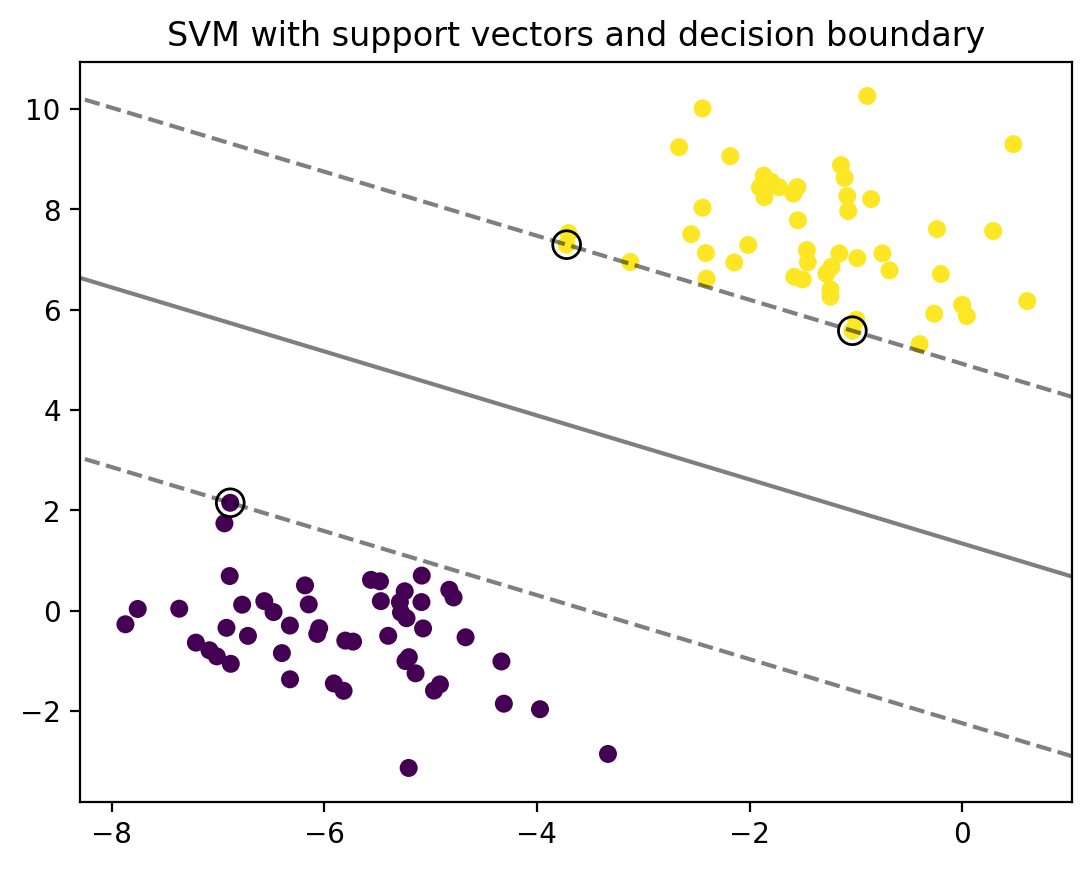

In [3]:
from sklearn import svm

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.viridis)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

ax.set_title('SVM with support vectors and decision boundary')
plt.show()


## 2. Kernel SVM

So far, all the models we've spoken about are those which cater to datasets where the relationship between classes is essentially linear - that is, a flat hyperplane is the right choice to separate the classes. But what if that isn't the case?  Let's try things out on a new toy dataset that is obviously **not linear** and check things out.

Text(0.5, 1.0, 'New Dataset')

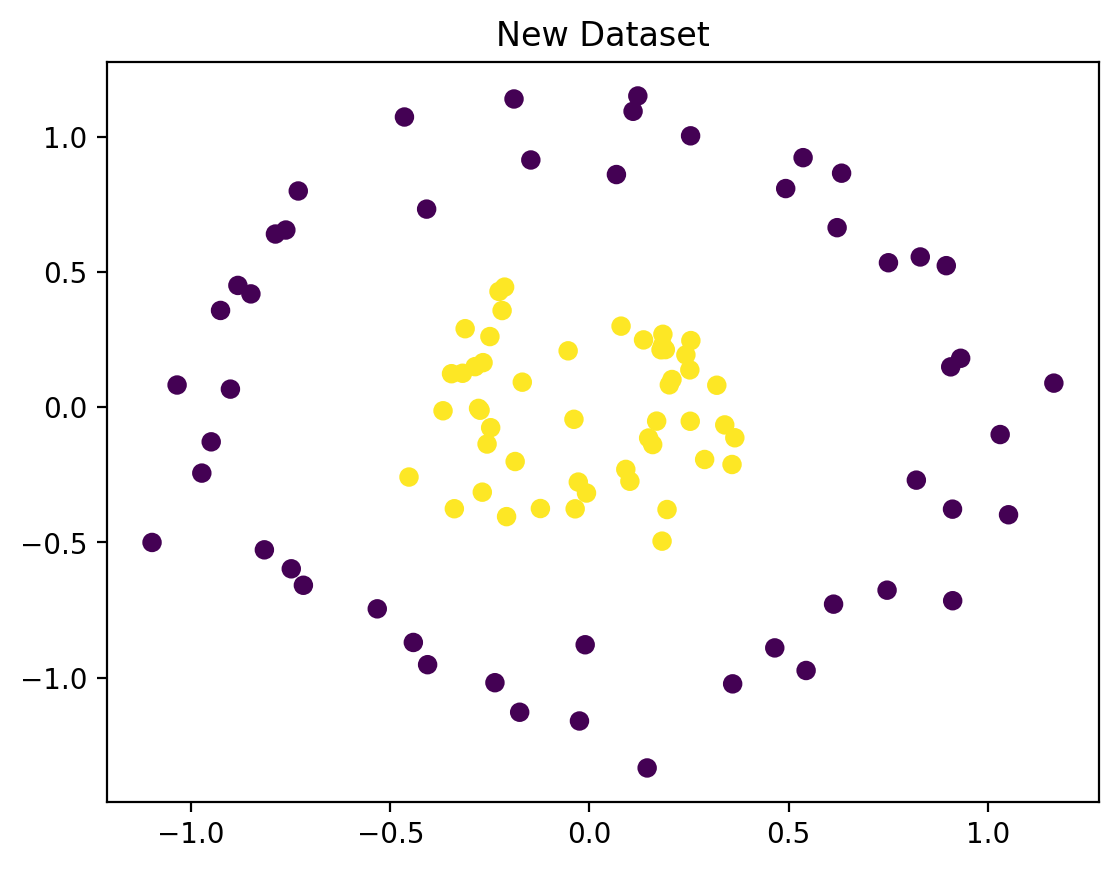

In [4]:
from sklearn.datasets import make_circles

X_circ, y_circ = make_circles(n_samples=100, factor=0.3, noise=0.1, random_state=0)

fig, ax = plt.subplots()
ax.scatter(X_circ[:,0], X_circ[:,1], c=y_circ)
plt.title('New Dataset')

Plot decision boundaries for different classifiers

In [5]:
## Function to plot decision boundaries

import numpy as np
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_boundary(X,y,clf,title='Decision Boundary'):
    fig, ax = plt.subplots()
    X0, X1 = X[:, 0], X[:, 1]
    xmesh, ymesh = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xmesh, ymesh, cmap=plt.cm.viridis, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.viridis, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

def plot_contours_knn(ax, xx, yy, kNN,X,y,**params):
    Z = kNN(np.c_[xx.ravel(), yy.ravel()],1,X,y)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_boundary_test_knn(X,y,kNN,title='Decision Boundary - KNN test'):
    fig, ax = plt.subplots()
    X0, X1 = X[:, 0], X[:, 1]
    xmesh, ymesh = make_meshgrid(X0, X1, h=0.5)
    plot_contours_knn(ax, xmesh, ymesh, kNN, X, y, cmap=plt.cm.viridis, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.viridis, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

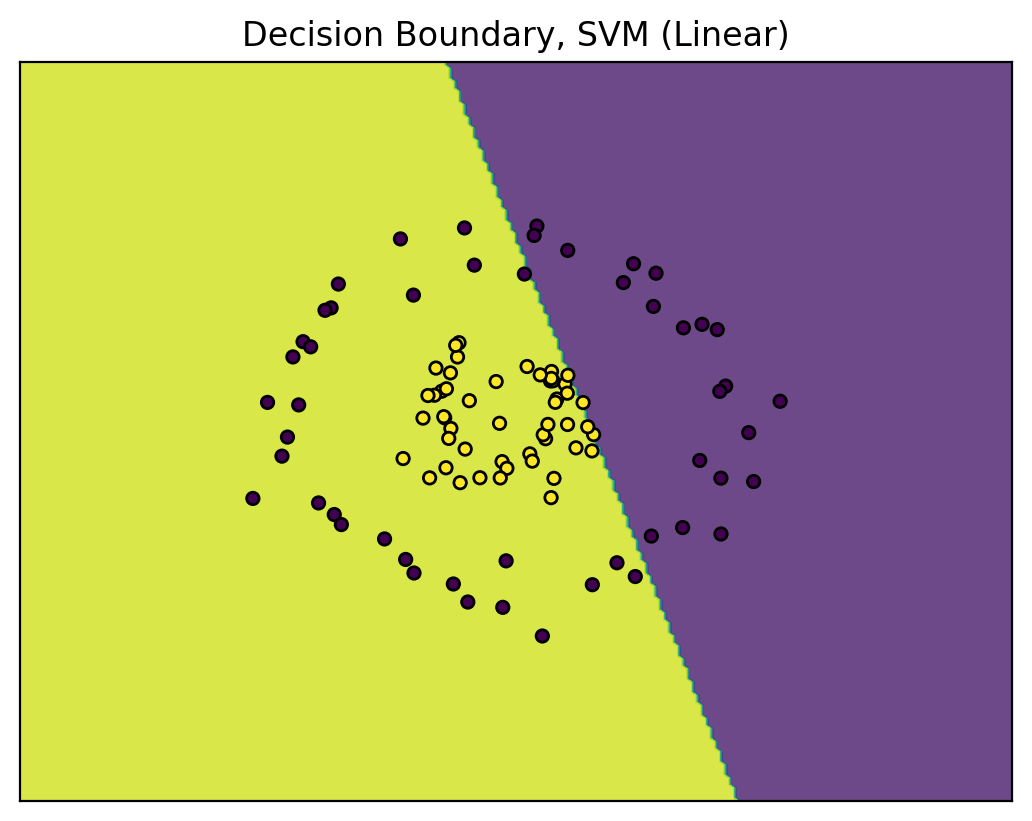

In [6]:
clf_lin = svm.SVC(kernel='linear')
clf_lin.fit(X_circ, y_circ)
plot_decision_boundary(X_circ,y_circ,clf_lin,'Decision Boundary, SVM (Linear)')

Hmm, that doesn't look very nice. You might now be reminded of a certain kernel trick, and the good news is that you can apply it to SVMs too!!

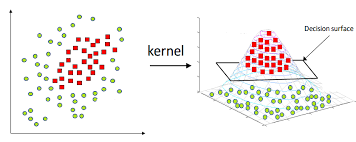

What if we use **Radial Basis function (RBF)** kernel??

The RBF kernel is defined as:

$$K(x, x') = exp(-\frac{\| x - x' \|^2}{2 \sigma^2})$$

In scikit-learn, $K(x, x') = exp(-\gamma \| x - x' \|^2)$ and $\gamma$ is a hyperparameter that defines the bandwidth of the Gaussian.

svm_c_gamma.png

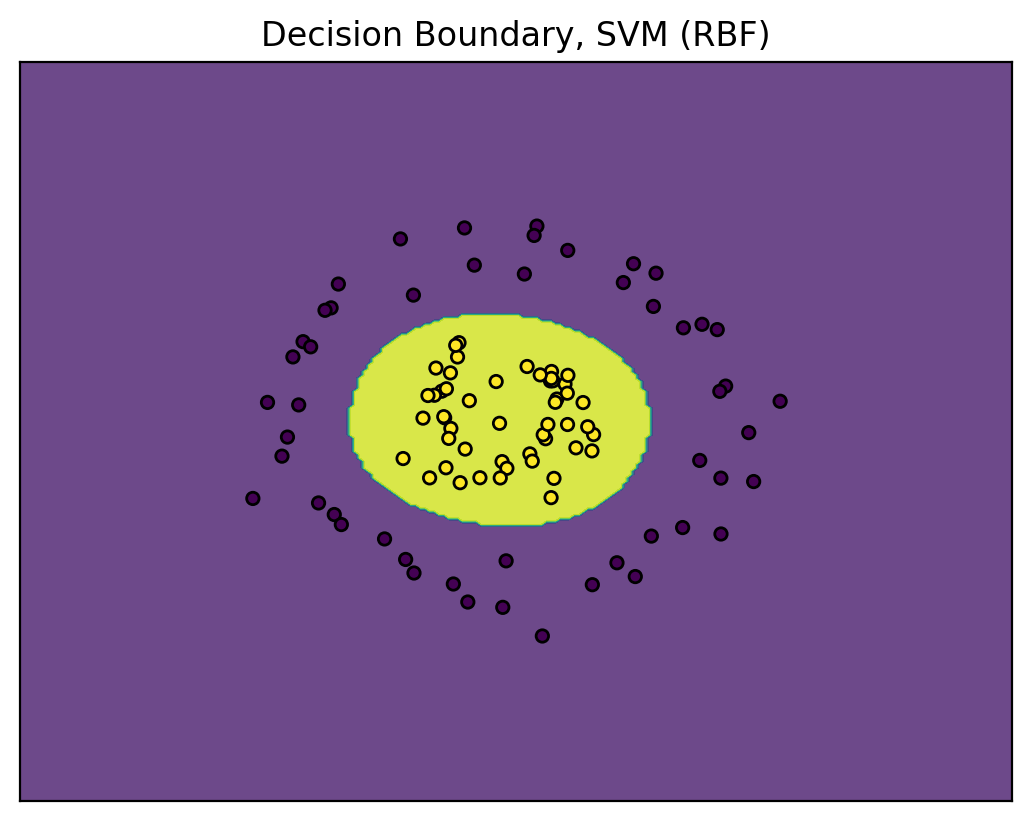

In [7]:
clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X_circ, y_circ)
plot_decision_boundary(X_circ,y_circ,clf_rbf,'Decision Boundary, SVM (RBF)')

What happens if we change the bandwidth? What if you change the kernel?

Options in kernel-SVM: kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’

In [8]:
clf_rbf = svm.SVC(kernel='rbf', C=.5, gamma=100)

clf_rbf.fit(X_circ, y_circ)
plot_decision_boundary(X_circ,y_circ,clf_rbf,'Decision Boundary, SVM (RBF)')

## 3. Nearest Neighbors Classifier

K-Nearest Neighbors (KNN) is perhaps, conceptually, the simplest classification method around. Mainly because it operates on a principle that is very easy to understand: democracy.

The class of a point is determined by letting its k-nearest neighbors "vote" on which class it should be in. The point is assigned to whichever class has the most votes. In the case of a tie, `k` is decreased by 1 until the tie is broken.

The advantage of democracy is that it is "nonlinear" - we can distinguish classes with very complex structures. Additionally, KNN has no hyperparameters other than the number of neighbors, which makes it an excellent baseline to compare more sophisticated algorithms against.

#### Implement KNN Classifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X, y)

clf_knn_noisy = KNeighborsClassifier(n_neighbors=5)
clf_knn_noisy.fit(X_noisy, y_noisy)

KNeighborsClassifier()

In [16]:
#plot_decision_boundary(X,y,clf_knn,'Decision Boundary, KNN (Clean)')
plot_decision_boundary(X_noisy,y_noisy,clf_knn_noisy,'Decision Boundary, KNN (Noisy)')

## 4. Decision Trees and Random Forests

Decision trees are a very powerful type of **discriminative** classification algorithm, and they are relatively easy to interpret. They also have the advantage of working well with discrete input variables (e.g. discrete feature spaces). Here's an example:
<p>
<center>
    <img src="https://miro.medium.com/max/381/0*ToYXqRes95eMvIKV.png" width=250>
</center>
</p>
The disadvantage of decision trees though, is that they are very prone to over-fitting. To combat this tendency of "one" tree to overfit, we use the idea of strength in numbers or averages, that is, an ensemble approach. An ensemble of many decision trees is called a "Random forest", and by training the forest of decision trees with subsets of the data (in a way similar to "bootstrapping"), the ensemble of models often produces an estimate that is relatively less overfit and prone to outliers.

To decide which variables to compare and where to split, decision trees use a "criterion" such as the [gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) to measure how impure the data are at a particular node, and keep splitting the parent nodes into smaller children nodes until all the nodes at the bottom of the tree contain elements of only a single class.

(1) Decision Tree

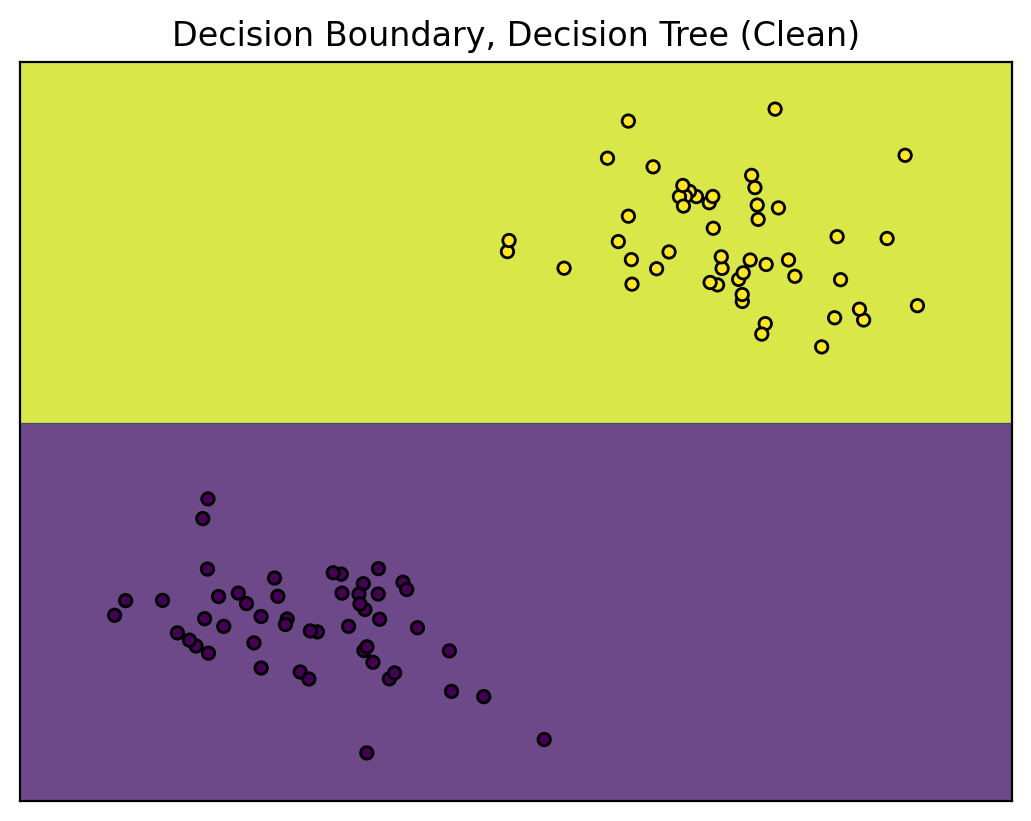

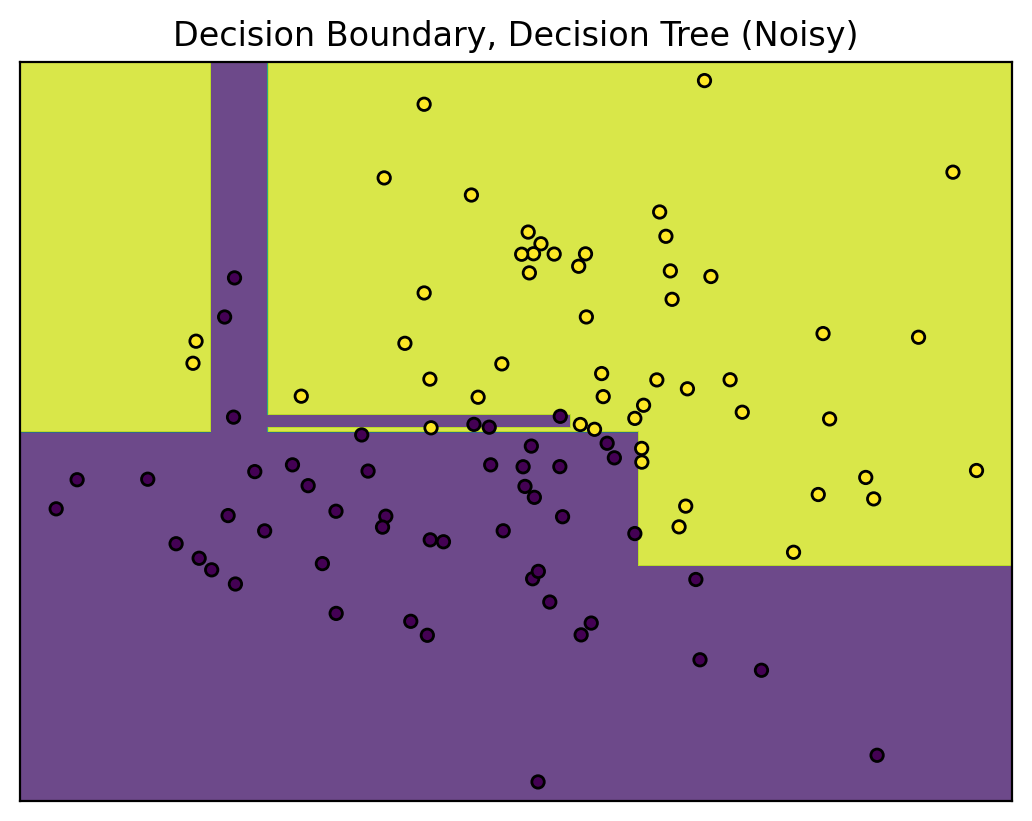

In [11]:
from sklearn.tree import DecisionTreeClassifier

clf_dtree=DecisionTreeClassifier(random_state=22)
clf_dtree.fit(X,y)

clf_noisy_dtree=DecisionTreeClassifier(random_state=22)
clf_noisy_dtree.fit(X_noisy,y_noisy)

plot_decision_boundary(X,y,clf_dtree,'Decision Boundary, Decision Tree (Clean)')
plot_decision_boundary(X_noisy,y_noisy,clf_noisy_dtree,'Decision Boundary, Decision Tree (Noisy)')

(2) Random Forest

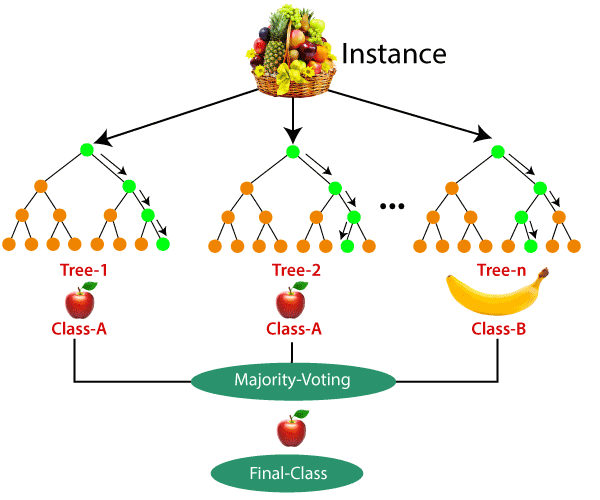

Image from: https://www.section.io/engineering-education/introduction-to-random-forest-in-machine-learning/

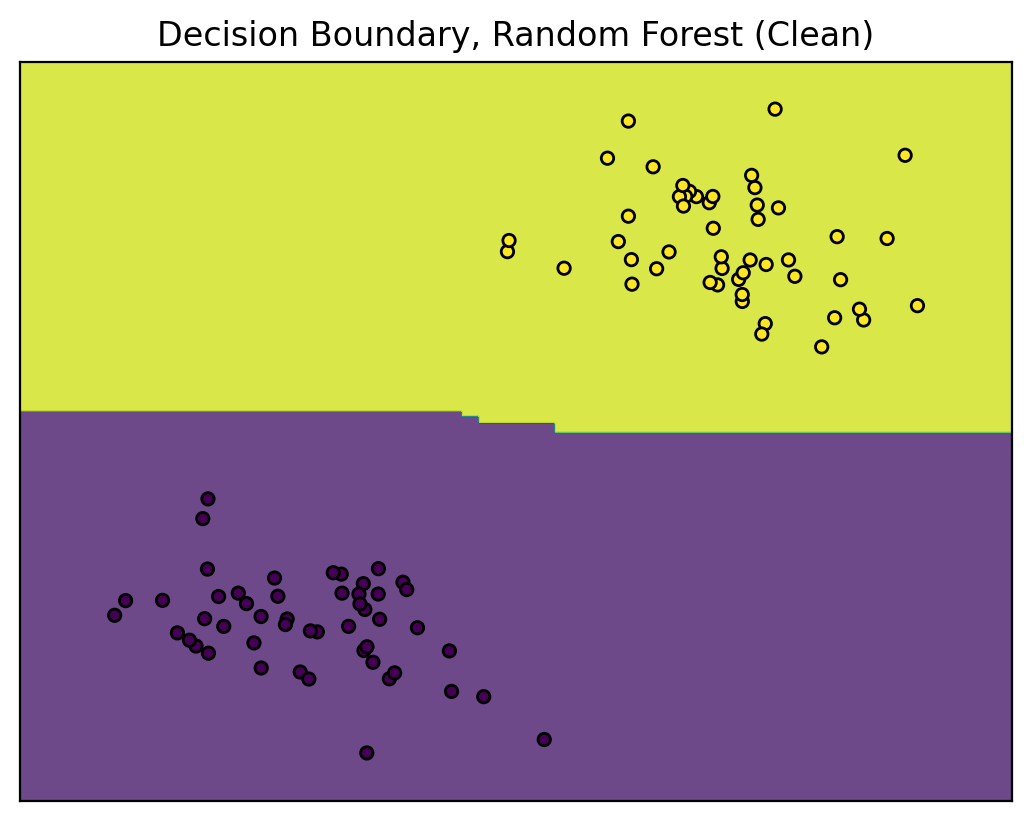

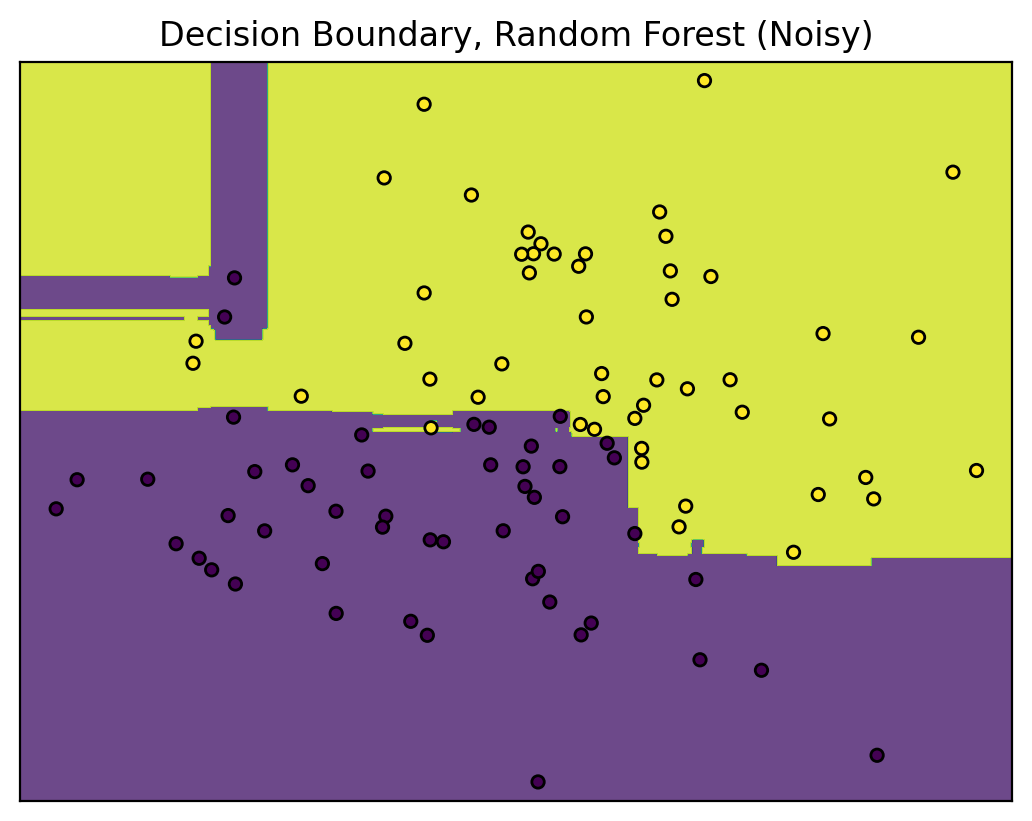

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=8)
clf_rf.fit(X,y)

clf_noisy_rf = RandomForestClassifier(random_state=8)
clf_noisy_rf.fit(X_noisy,y_noisy)

plot_decision_boundary(X,y,clf_rf,'Decision Boundary, Random Forest (Clean)')
plot_decision_boundary(X_noisy,y_noisy,clf_noisy_rf,'Decision Boundary, Random Forest (Noisy)')

### 5. Multinomial logistic regression

#### 5.1. Cross-entropy loss

Let $y_i = {0, 1}$ denote the label for the ith point and $\widehat{y} = g (z_i)$ be the prediction (probability) of the same, and $z_i$ is the score (of class 1) for the ith point ($x_i$).


The cross-entropy loss is defined as:

$$ CE(y,\widehat{y}) = - \sum_{i=1}^n y_i \log ( \widehat{y} ) + (1 - y_i) \log( 1 - \widehat{y}). $$

When we select our sigmoid function for the link function $g$, then minimizing this objective is equivalent to maximizing the likelihood of our parameters given our observations!

#### 5.2. Softmax regression

Recall that logistic regression employs the logit (or sigmoid) link function: $g(t) = \frac{1}{1 + e^{-t}}$.

Now, we want to extend this basic model to a multi-class setting. If we follow the same steps, this boils down to *softmax regression*.

Let $z_c$ equal to the score of a point ($x$) associated with class $c$. The probability of class $c$ is given by:
$$y_c = \frac{\exp(z_c)}{\sum_{d=1}^C \exp(z_d) }.$$



Automatically created module for IPython interactive environment
Sparsity with L1 penalty: 74.34%
Test score with L1 penalty: 0.8336
Example run in 33.391 s


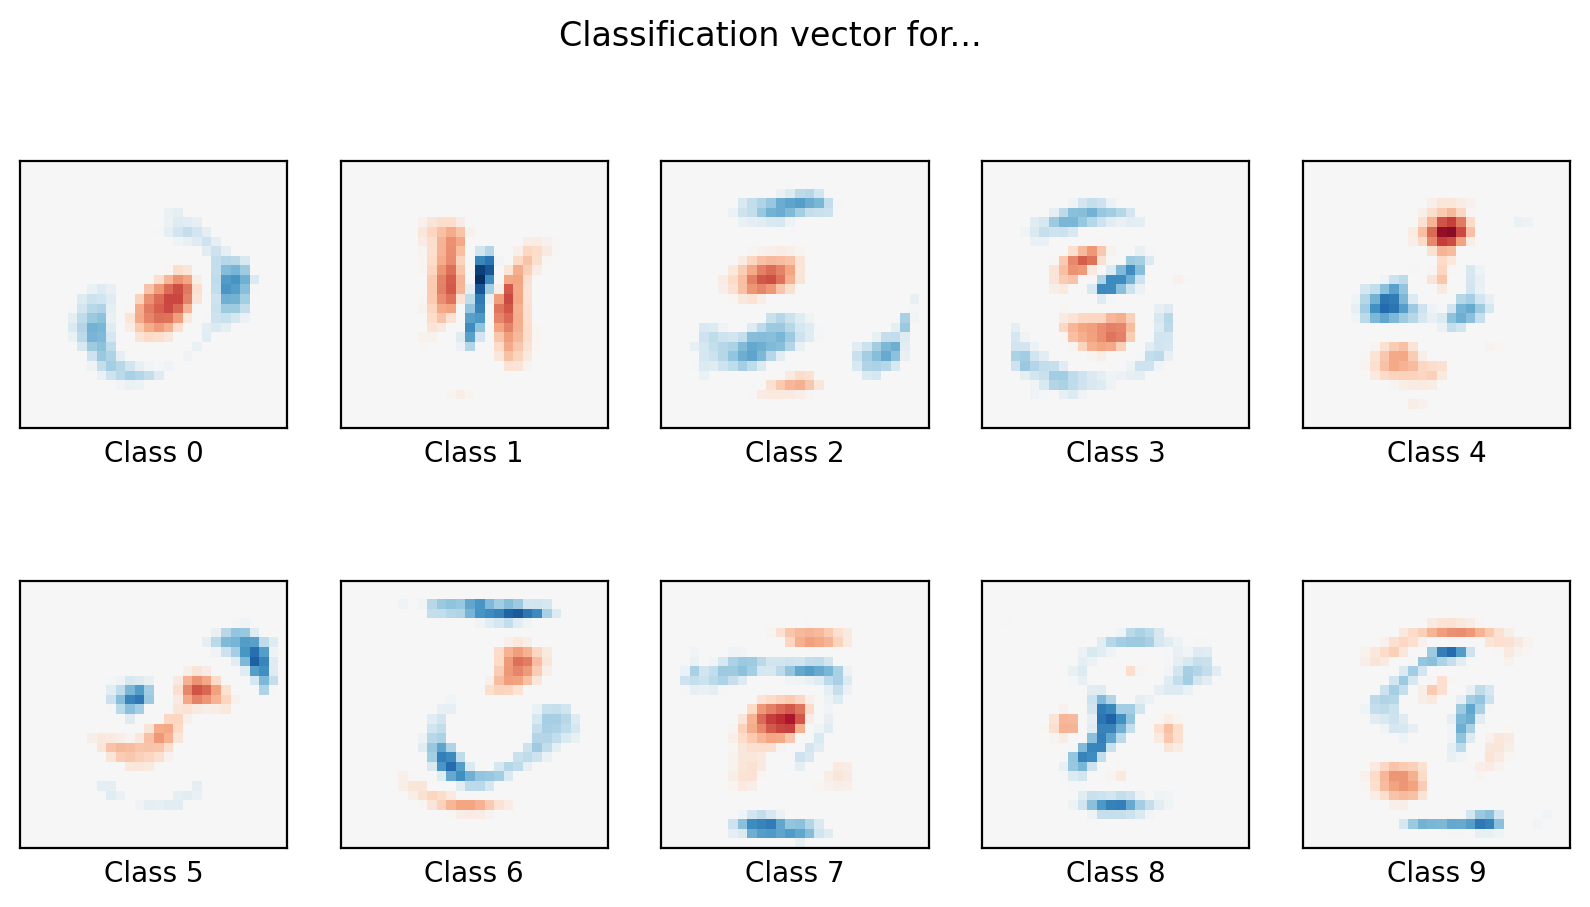

In [13]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Author: Arthur Mensch <arthur.mensch@m4x.org>
# License: BSD 3 clause

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(
    C=50. / train_samples, penalty='l1', solver='saga', tol=0.1
)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()


#### Overview of Approaches

- **Support Vector Machine**: Tries to maximize the margin between classes. Combines the use of the hinge loss and regularization (L2) on the decision variable weights.
- **Kernel SVM**: Using a kernel instead of L2 distance allows nonlinear decision boundaries to be learned.
- **K-Nearest Neighbor Classifier**: Non-parameteric approach for classification. Uses consensus amongst the neighbors from a query point.
- **Random Forests and Decision Trees**: Uses heuristic optimization approaches to try to maximize label purity measures in final outputs - all points mapped to the same point in the tree are from the same class with high probability.

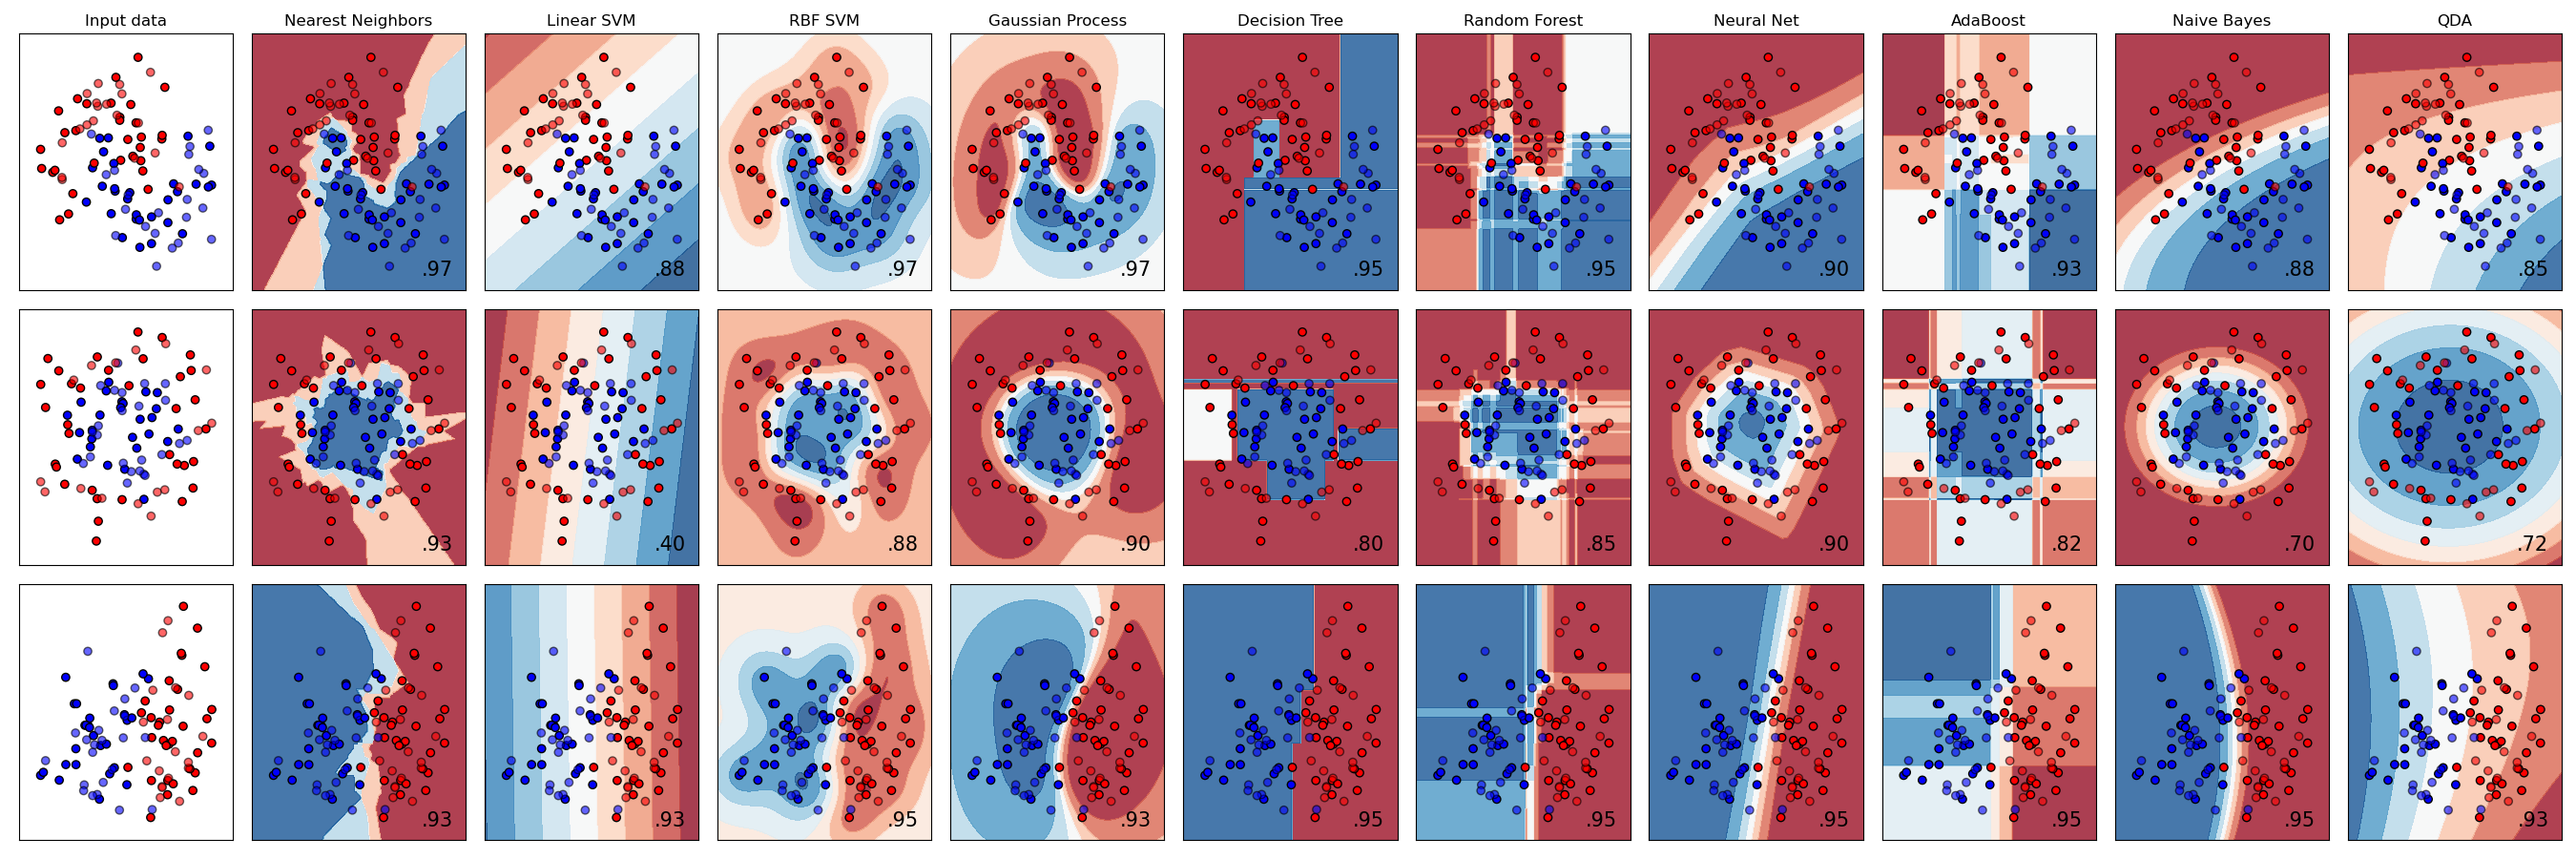

Q:  For all of the 4 models described above, indicate:

   (i) what type of classifier it is (linear vs nonlinear, parametric vs non-parametric, discriminative vs generative),

   (ii) list the hyperparameters needed for each, and

   (iii) detail one advantage and one disadvantage in using the approach.








**Your answers here:**




> Text goes here.






___

Contributors: Max Dabagia, Aishwarya Balwani, Mehdi Azabou, Eva Dyer